<a href="https://colab.research.google.com/github/norannali/Swarm-Intelligence-for-Maze-Solving-ABC-vs-ACO-vs-PSO/blob/main/Swarm_Intelligence_for_Maze_Solving_ABC_vs_ACO_vs_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import deque


In [2]:
def generate_maze(width=20, height=20, obstacle_density=0.2):
    # Initialize maze with empty cells
    maze = np.zeros((height, width), dtype=int)

    # Create a valid path from start (0,0) to goal (height-1, width-1)
    x, y = 0, 0
    path = [(x, y)]
    while x < height - 1 or y < width - 1:
        if x == height - 1:
            y += 1
        elif y == width - 1:
            x += 1
        else:
            if random.random() < 0.5:
                x += 1
            else:
                y += 1
        path.append((x, y))

    # Set all cells to obstacle with given probability
    for i in range(height):
        for j in range(width):
            if random.random() < obstacle_density:
                maze[i][j] = 1

    # Clear the path to ensure connectivity
    for (i, j) in path:
        maze[i][j] = 0

    # Set start and goal
    maze[0][0] = 2  # Start
    maze[height - 1][width - 1] = 3  # Goal

    return maze

In [3]:
def visualize_maze(maze):
    height, width = maze.shape
    color_map = {
        0: "#D3D3D3",  # Empty - Light Gray
        1: "#404040",  # Obstacle - Dark Gray
        2: "#00FF00",  # Start - Green
        3: "#FF0000",  # Goal - Red
    }

    fig, ax = plt.subplots()
    for i in range(height):
        for j in range(width):
            value = maze[i, j]
            color = color_map.get(value, "#FFFFFF")
            ax.add_patch(plt.Rectangle((j, height - i - 1), 1, 1, color=color))

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])

    # Legend
    legend_patches = [
        mpatches.Patch(color=color_map[2], label='Start'),
        mpatches.Patch(color=color_map[3], label='Goal'),
        mpatches.Patch(color=color_map[0], label='Empty'),
        mpatches.Patch(color=color_map[1], label='Obstacle')
    ]
    plt.legend(handles=legend_patches, loc='upper right')
    plt.title("Generated Maze with Guaranteed Path")
    plt.show()

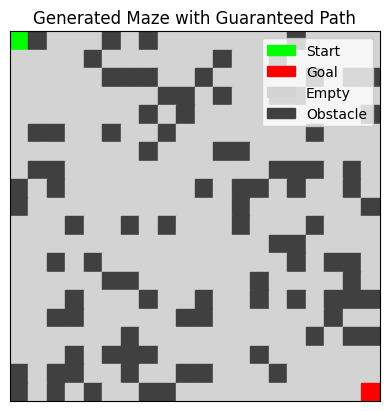

In [4]:
maze = generate_maze(width=20, height=20, obstacle_density=0.25)
visualize_maze(maze)

In [5]:
#  Common functions for all algorithms
def get_start_goal(maze):
    start, goal = None, None
    for i in range(len(maze)):
        for j in range(len(maze[0])):
            if maze[i][j] == 2:
                start = (i, j)
            elif maze[i][j] == 3:
                goal = (i, j)
    return start, goal

def is_valid_move(maze, pos):
    x, y = pos
    if 0 <= x < len(maze) and 0 <= y < len(maze[0]):
        return maze[x][y] != 1  # Not an obstacle
    return False

def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def get_neighbors(pos, maze):
    x, y = pos
    neighbors = []
    for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:  # Right, Down, Left, Up
        new_pos = (x + dx, y + dy)
        if is_valid_move(maze, new_pos):
            neighbors.append(new_pos)
    return neighbors

In [6]:
import random
from collections import deque
from IPython.display import clear_output

class ABCMazeSolver:
    def __init__(self, maze, num_bees=30, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_bees = num_bees
        self.max_iter = max_iter
        self.population = []
        self.fitness = []
        self.best_solution = None
        self.best_fitness = float('inf')

    @staticmethod
    def bfs_path(maze, start, goal):
        queue = deque([[start]])
        visited = set()
        visited.add(start)

        while queue:
            path = queue.popleft()
            current = path[-1]
            if current == goal:
                return path
            for neighbor in get_neighbors(current, maze):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(path + [neighbor])
        return None

    def initialize_bees(self):
        base_path = ABCMazeSolver.bfs_path(self.maze, self.start, self.goal)
        if not base_path:
            print("No path found from start to goal even with BFS.")
            return
        for _ in range(self.num_bees):
            self.population.append(base_path)
            self.fitness.append(len(base_path))
        self.best_solution = base_path
        self.best_fitness = len(base_path)

    def mutate_path(self, path):
        if len(path) <= 2:
            return path
        for _ in range(3):
            i = random.randint(1, len(path) - 3)
            j = random.randint(i + 1, len(path) - 2)
            sub_start = path[i]
            sub_goal = path[j]
            temp_path = [sub_start]
            visited = set(temp_path)
            current = sub_start
            while current != sub_goal:
                neighbors = get_neighbors(current, self.maze)
                neighbors = [n for n in neighbors if n not in visited]
                if not neighbors:
                    break
                current = min(neighbors, key=lambda p: manhattan_distance(p, sub_goal))
                temp_path.append(current)
                visited.add(current)
            if current == sub_goal:
                return path[:i] + temp_path + path[j+1:]
        return path  # fallback if no shortcut works

    def optimize(self):
        self.initialize_bees()
        if not self.population:
            print("Failed to find any initial paths to goal.")
            return None
        for iteration in range(self.max_iter):
            new_population = []
            new_fitness = []
            for path in self.population:
                new_path = self.mutate_path(path)
                if new_path[-1] == self.goal:
                    fitness_val = len(new_path)
                    new_population.append(new_path)
                    new_fitness.append(fitness_val)
                    if fitness_val < self.best_fitness:
                        self.best_fitness = fitness_val
                        self.best_solution = new_path
            if new_population:
                self.population = new_population
                self.fitness = new_fitness
            clear_output(wait=True)
            print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {self.best_fitness}")
        return self.best_solution

In [7]:
def plot_solution(maze, path, algorithm_name="Swarm Algorithm"):
    if not path or path[-1] != get_start_goal(maze)[1]:
        print("No valid path found.")
        visualize_maze(maze)
        return

    height, width = maze.shape
    color_map = {
        0: "#D3D3D3",  # Empty - Light Gray
        1: "#404040",  # Obstacle - Dark Gray
        2: "#00FF00",  # Start - Green
        3: "#FF0000",  # Goal - Red
    }

    fig, ax = plt.subplots()
    for i in range(height):
        for j in range(width):
            value = maze[i, j]
            color = color_map.get(value, "#FFFFFF")
            ax.add_patch(plt.Rectangle((j, height - i - 1), 1, 1, color=color))

    # Draw path
    for (x, y) in path:
        ax.add_patch(plt.Circle((y + 0.5, height - x - 0.5), 0.2, color="blue"))

    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks([])
    plt.yticks([])
    num_points = len(path)
    plt.title(f"Path Found by {algorithm_name}\nPath Length: {num_points} points")

    plt.show()

Iteration 100/100 | Best Path Length: 39


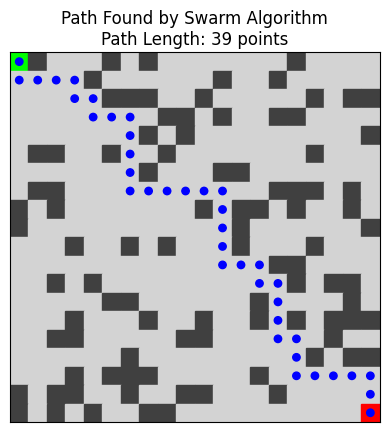

In [8]:
abc_solver = ABCMazeSolver(maze, num_bees=30, max_iter=100)
solution = abc_solver.optimize()
plot_solution(maze, solution)

In [9]:
import random
import numpy as np
from collections import deque
from IPython.display import clear_output

class ACOMazeSolver:
    def __init__(self, maze, num_ants=30, alpha=1, beta=3, evaporation_rate=0.5, Q=100, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_ants = num_ants
        self.alpha = alpha  # pheromone influence
        self.beta = beta    # heuristic influence
        self.evaporation_rate = evaporation_rate
        self.Q = Q
        self.max_iter = max_iter
        self.pheromone = np.ones_like(maze, dtype=float)
        self.best_path = None
        self.best_length = float('inf')

    def _heuristic(self, pos):
        return 1 / (manhattan_distance(pos, self.goal) + 1)

    def _construct_path(self):
        path = [self.start]
        visited = set([self.start])
        current = self.start

        while current != self.goal:
            neighbors = get_neighbors(current, self.maze)
            neighbors = [n for n in neighbors if n not in visited]
            if not neighbors:
                return None

            probs = []
            for n in neighbors:
                tau = self.pheromone[n]
                eta = self._heuristic(n)
                probs.append((tau ** self.alpha) * (eta ** self.beta))
            total = sum(probs)
            if total == 0:
                return None
            probs = [p / total for p in probs]
            next_cell = random.choices(neighbors, weights=probs, k=1)[0]
            path.append(next_cell)
            visited.add(next_cell)
            current = next_cell
        return path

    def _update_pheromones(self, all_paths):
        self.pheromone *= (1 - self.evaporation_rate)
        for path in all_paths:
            length = len(path)
            for cell in path:
                self.pheromone[cell] += self.Q / length

    def optimize(self):
        for iteration in range(self.max_iter):
            all_paths = []
            for _ in range(self.num_ants):
                path = self._construct_path()
                if path and path[-1] == self.goal:
                    all_paths.append(path)
                    if len(path) < self.best_length:
                        self.best_length = len(path)
                        self.best_path = path
            self._update_pheromones(all_paths)
            clear_output(wait=True)
            print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {self.best_length}")
        return self.best_path

In [10]:
aco_solver = ACOMazeSolver(maze)
best_path = aco_solver.optimize()

if best_path:
    print("Best path found:", best_path)
else:
    print("No valid path found.")

Iteration 100/100 | Best Path Length: 39
Best path found: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (5, 6), (6, 6), (7, 6), (7, 7), (7, 8), (8, 8), (8, 9), (9, 9), (10, 9), (11, 9), (12, 9), (13, 9), (13, 10), (13, 11), (14, 11), (15, 11), (15, 12), (15, 13), (15, 14), (15, 15), (16, 15), (17, 15), (18, 15), (19, 15), (19, 16), (19, 17), (19, 18), (19, 19)]


Iteration 100/100 | Best Path Length: 39


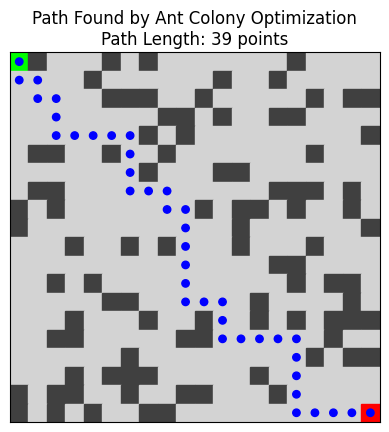

In [11]:
# After running ACO
aco_path = aco_solver.optimize()
plot_solution(maze, aco_path, algorithm_name="Ant Colony Optimization")

In [13]:
class PSOMazeSolver:
    def __init__(self, maze, num_particles=30, w=0.5, c1=1, c2=2, max_iter=100):
        self.maze = maze
        self.start, self.goal = get_start_goal(maze)
        self.num_particles = num_particles
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.max_iter = max_iter
        self.particles = []
        self.velocities = []
        self.pbest_positions = []
        self.pbest_scores = []
        self.gbest_position = None
        self.gbest_score = float('inf')
        self.pheromone = np.zeros_like(maze, dtype=float)

    def _initialize_particles(self):
        for _ in range(self.num_particles):
            path = self._generate_random_path()
            if not path or path[-1] != self.goal:
                path = self._find_path_bfs(self.start, self.goal) or [self.start, self.goal]
            self.particles.append(path)
            self.velocities.append([(0,0)] * len(path))
            score = self._calculate_fitness(path)
            self.pbest_positions.append(path.copy())
            self.pbest_scores.append(score)
            if score < self.gbest_score:
                self.gbest_score = score
                self.gbest_position = path.copy()

    def _generate_random_path(self):
        path = [self.start]
        current = self.start
        visited = set([current])
        max_steps = 2 * (len(self.maze) + len(self.maze[0]))
        for _ in range(max_steps):
            if current == self.goal: break
            neighbors = get_neighbors(current, self.maze)
            neighbors = [n for n in neighbors if n not in visited]
            if not neighbors: break
            next_cell = random.choice(neighbors)
            path.append(next_cell)
            visited.add(next_cell)
            current = next_cell
        return path

    def _find_path_bfs(self, start, goal):
        queue = deque([[start]])
        visited = set([start])
        while queue:
            path = queue.popleft()
            current = path[-1]
            if current == goal: return path
            for neighbor in get_neighbors(current, self.maze):
                if neighbor not in visited:
                    visited.add(neighbor)
                    queue.append(path + [neighbor])
        return None

    def _calculate_fitness(self, path):
        if not path or path[-1] != self.goal: return float('inf')
        length_score = len(path)
        obstacle_penalty = sum(1 for cell in path if self.maze[cell] == 1)
        turn_penalty = 0
        if len(path) > 2:
            for i in range(1, len(path)-1):
                prev_dir = (path[i][0]-path[i-1][0], path[i][1]-path[i-1][1])
                next_dir = (path[i+1][0]-path[i][0], path[i+1][1]-path[i][1])
                if prev_dir != next_dir: turn_penalty += 0.1
        return length_score + 10*obstacle_penalty + turn_penalty

    def _update_velocity(self, particle_idx):
        if particle_idx >= len(self.particles): return
        particle = self.particles[particle_idx]
        new_velocity = []
        for i in range(min(len(particle), len(self.pbest_positions[particle_idx]), len(self.gbest_position))):
            pos = particle[i]
            pbest_pos = self.pbest_positions[particle_idx][i] if i < len(self.pbest_positions[particle_idx]) else pos
            gbest_pos = self.gbest_position[i] if i < len(self.gbest_position) else pos
            vel = self.velocities[particle_idx][i] if i < len(self.velocities[particle_idx]) else (0,0)
            r1, r2 = random.random(), random.random()
            new_vel_x = (self.w * vel[0] + self.c1 * r1 * (pbest_pos[0] - pos[0]) + self.c2 * r2 * (gbest_pos[0] - pos[0]))
            new_vel_y = (self.w * vel[1] + self.c1 * r1 * (pbest_pos[1] - pos[1]) + self.c2 * r2 * (gbest_pos[1] - pos[1]))
            max_vel = 2
            new_vel_x = max(-max_vel, min(max_vel, new_vel_x))
            new_vel_y = max(-max_vel, min(max_vel, new_vel_y))
            new_velocity.append((new_vel_x, new_vel_y))
        self.velocities[particle_idx] = new_velocity

    def _update_position(self, particle_idx):
        if particle_idx >= len(self.particles): return
        old_path = self.particles[particle_idx]
        new_path = [self.start]
        for i in range(1, len(old_path)):
            vel_x, vel_y = self.velocities[particle_idx][i-1] if (i-1) < len(self.velocities[particle_idx]) else (0,0)
            new_x = round(old_path[i][0] + vel_x)
            new_y = round(old_path[i][1] + vel_y)
            new_pos = (new_x, new_y)
            if is_valid_move(self.maze, new_pos) and new_pos not in new_path:
                new_path.append(new_pos)
            else:
                neighbors = get_neighbors(old_path[i], self.maze)
                valid_neighbors = [n for n in neighbors if n not in new_path]
                if valid_neighbors: new_path.append(random.choice(valid_neighbors))
                else: new_path.append(old_path[i])
        if new_path[-1] != self.goal and self.goal not in new_path:
            last_pos = new_path[-1]
            path_to_goal = self._find_path_bfs(last_pos, self.goal)
            if path_to_goal: new_path.extend(path_to_goal[1:])
        self.particles[particle_idx] = new_path
        current_score = self._calculate_fitness(new_path)
        if current_score < self.pbest_scores[particle_idx]:
            self.pbest_positions[particle_idx] = new_path.copy()
            self.pbest_scores[particle_idx] = current_score
            if current_score < self.gbest_score:
                self.gbest_score = current_score
                self.gbest_position = new_path.copy()

    def _update_pheromone_trail(self):
        self.pheromone *= 0.9
        if self.gbest_position:
            for cell in self.gbest_position:
                self.pheromone[cell] += 1

    def optimize(self):
        self._initialize_particles()
        for iteration in range(self.max_iter):
            try:
                for i in range(len(self.particles)):
                    self._update_velocity(i)
                    self._update_position(i)
                self._update_pheromone_trail()
                clear_output(wait=True)
                current_best = len(self.gbest_position) if self.gbest_position else 'N/A'
                print(f"Iteration {iteration+1}/{self.max_iter} | Best Path Length: {current_best}")
            except Exception as e:
                print(f"Error in iteration {iteration+1}: {str(e)}")
                continue
        return self.gbest_position

Iteration 50/50 | Best Path Length: 39
A Path Has Been Found!
Path Length : 39


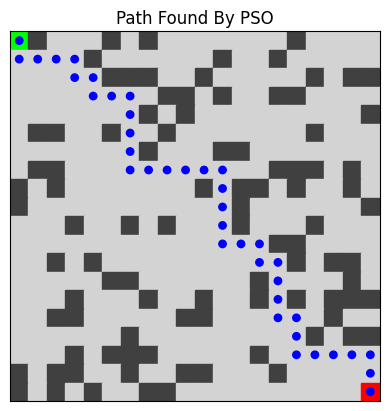

In [16]:
# Create the PSO solver object and run the algorithm
pso_solver = PSOMazeSolver(maze, num_particles=20, max_iter=50)
pso_path = pso_solver.optimize()

# Display results
if pso_path and pso_path[-1] == get_start_goal(maze)[1]:
    print("A Path Has Been Found!")
    print(f"Path Length : {len(pso_path)}")

    # Visualize the maze along with the path
    height, width = maze.shape  # Get maze dimensions
    # Define colors for different maze cell types:
    # 0 = path (light gray), 1 = wall (dark gray), 2 = start (green), 3 = goal (red)
    color_map = {0: "#D3D3D3", 1: "#404040", 2: "#00FF00", 3: "#FF0000"}

    # Create the plot
    fig, ax = plt.subplots()

    # Draw the maze grid
    for i in range(height):
        for j in range(width):
            value = maze[i, j]
            color = color_map.get(value, "#FFFFFF")  # Default to white if value not found
            ax.add_patch(plt.Rectangle((j, height - i - 1), 1, 1, color=color))  # Draw cell

    # Draw the path found by PSO using blue circles
    for (x, y) in pso_path:
        ax.add_patch(plt.Circle((y + 0.5, height - x - 0.5), 0.2, color="blue"))

    # Set plot limits and appearance
    plt.xlim(0, width)
    plt.ylim(0, height)
    plt.gca().set_aspect('equal', adjustable='box')  # Keep square aspect ratio
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.title("Path Found By PSO")  # Set plot title
    plt.show()
else:
    # If no valid path was found, print a message and show the maze only
    print("No valid path found.")
    visualize_maze(maze)

Iteration 100/100 | Best Path Length: 39


Comparison Results:
Algorithm       Path Length     Time           
---------------------------------------------
ABC             39              0.5905
ACO             43              1.8611
PSO             39              1.1881


<Figure size 1800x500 with 0 Axes>

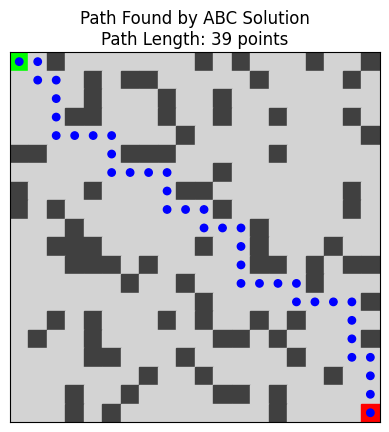

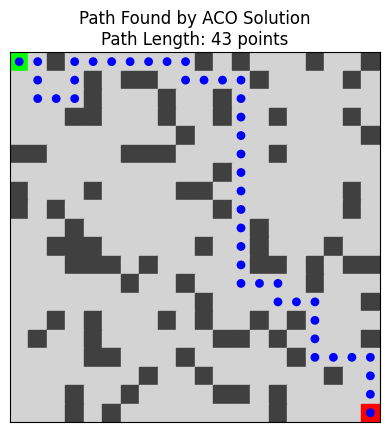

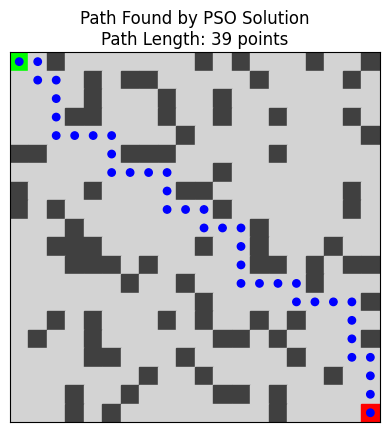

<Figure size 640x480 with 0 Axes>

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

def compare_algorithms(maze, num_agents=30, max_iter=100):
    """
    Compare the performance of ABC, ACO, and PSO algorithms on the same maze.

    Parameters:
        maze: The maze matrix
        num_agents: Number of agents (bees, ants, particles) for each algorithm
        max_iter: Maximum number of iterations per algorithm
    """

    # Dictionary to store results for each algorithm
    results = {
        'ABC': {'time': 0, 'length': 0, 'convergence': []},
        'ACO': {'time': 0, 'length': 0, 'convergence': []},
        'PSO': {'time': 0, 'length': 0, 'convergence': []}
    }

    # Run ABC Algorithm
    print("Running ABC Algorithm...")
    start_time = time.time()
    abc_solver = ABCMazeSolver(maze, num_bees=num_agents, max_iter=max_iter)
    abc_path = abc_solver.optimize()
    results['ABC']['time'] = time.time() - start_time
    results['ABC']['length'] = len(abc_path) if abc_path else float('inf')
    results['ABC']['convergence'] = abc_solver.best_fitness

    # Run ACO Algorithm
    print("\nRunning ACO Algorithm...")
    start_time = time.time()
    aco_solver = ACOMazeSolver(maze, num_ants=num_agents, max_iter=max_iter)
    aco_path = aco_solver.optimize()
    results['ACO']['time'] = time.time() - start_time
    results['ACO']['length'] = len(aco_path) if aco_path else float('inf')
    results['ACO']['convergence'] = aco_solver.best_length

    # Run PSO Algorithm
    print("\nRunning PSO Algorithm...")
    start_time = time.time()
    pso_solver = PSOMazeSolver(maze, num_particles=num_agents, max_iter=max_iter)
    pso_path = pso_solver.optimize()
    results['PSO']['time'] = time.time() - start_time
    results['PSO']['length'] = len(pso_path) if pso_path else float('inf')
    results['PSO']['convergence'] = pso_solver.gbest_score

    # Print comparison results
    print("\n\nComparison Results:")
    print(f"{'Algorithm':<15} {'Path Length':<15} {'Time':<15}")
    print("-"*45)
    for algo in results:
        print(f"{algo:<15} {results[algo]['length']:<15} {results[algo]['time']:.4f}")

    # Visualize paths for each algorithm
    plt.figure(figsize=(18, 5))

    if abc_path:
        plot_solution(maze, abc_path, "ABC Solution")
    else:
        visualize_maze(maze)
        plt.title("ABC - No Path Found")

    if aco_path:
        plot_solution(maze, aco_path, "ACO Solution")
    else:
        visualize_maze(maze)
        plt.title("ACO - No Path Found")

    if pso_path:
        plot_solution(maze, pso_path, "PSO Solution")
    else:
        visualize_maze(maze)
        plt.title("PSO - No Path Found")

    plt.tight_layout()
    plt.show()

    return results

# Generate a new maze
new_maze = generate_maze(width=20, height=20, obstacle_density=0.25)
visualize_maze(new_maze)

# Compare the algorithms on the generated maze
comparison_results = compare_algorithms(new_maze, num_agents=30, max_iter=100)